# Pedestrian Collisions in Toronto 

Being a pedestrian in Toronto all my life, I wanted to study the relationship between different factors regarding pedestrian collisions in Toronto. Luckily, great dataset was available on Toronto Police Service Public Safety Data Portal. 

Looking at the dataset, I realized that I need to first understand and clean the dataset before starting the analysis. 

In [124]:
# import all packages
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
%matplotlib inline

In [125]:
# settings to display all columns 
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [199]:
# import plotly
import plotly as py
import plotly.figure_factory as ff
from plotly import offline as pyo
pyo.init_notebook_mode(connected=True)

In [150]:
# saving csv in dataframe 
df = pd.read_csv('Pedestrians.csv')

# visualizing the dataframe 
df.head(3)

,X,Y,Index_,ACCNUM,YEAR,DATE,TIME,Hour,STREET1,STREET2,OFFSET,ROAD_CLASS,District,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Division,Ward_Name,Ward_ID,Hood_ID,Hood_Name,ObjectId
0,-79.369525,43.668101,80632108,6001446484,2016,2016-08-16T04:00:00.000Z,917,9,WELLESLEY ST E,PARLIAMENT ST,,Minor Arterial,Toronto and East York,43.668101,-79.369525,Intersection,At Intersection,Traffic Signal,Rain,Daylight,Wet,Non-Fatal Injury,Pedestrian Collisions,Driver,20 to 24,None,0,East,"Automobile, Station Wagon",Turning Left,Failed to Yield Right of Way,Inattentive,,,,,,,Yes,,Yes,,,NaN,,,,Yes,,,,51,NaN,NaN,71,NaN,1001
1,-79.369525,43.668101,80632109,6001446484,2016,2016-08-16T04:00:00.000Z,917,9,WELLESLEY ST E,PARLIAMENT ST,,Minor Arterial,Toronto and East York,43.668101,-79.369525,Intersection,At Intersection,Traffic Signal,Rain,Daylight,Wet,Non-Fatal Injury,Pedestrian Collisions,Pedestrian,65 to 69,Major,0,West,,,,,Vehicle turns left while ped crosses with ROW at inter.,Crossing with right of way,Normal,,,,Yes,,Yes,,,NaN,,,,Yes,,,,51,NaN,NaN,71,NaN,1002
2,-79.393894,43.710574,80175408,4002986275,2014,2014-09-26T04:00:00.000Z,918,9,REDPATH AVE,BROADWAY AVE,,Collector,Toronto and East York,43.710574,-79.393894,Intersection,At Intersection,Stop Sign,Clear,Daylight,Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,55 to 59,None,0,South,Police Vehicle,Turning Left,Failed to Yield Right of Way,Normal,,,,,,,Yes,,,,,NaN,Yes,,,Yes,,,,53,NaN,NaN,104,NaN,1003


In [127]:
# total number of columns 
df.columns.shape

(57,)

In [128]:
# drop columns with all their values NaN 
df.dropna(axis=1,how='all', inplace=True)

In [129]:
# 4 columns are removed 
df.columns.shape

(53,)

In [130]:
# any duplicated rows? 
df.duplicated().sum()

0

In [131]:
# any duplicated columns?
# seeing that latitude, longitude are duplicated, keeping the last occurrence
df = df.T.drop_duplicates(keep="last").T

Now, we have a dataset of no duplicated rows or columns. 

For this analysis, the factors I have decided to study are: 

- Driver Condition vs Pedestrian Condition 
- Driver Action vs Pedestrian Condition 
- Trend over Time 
- Age of the Pedestrian vs Driver 
- Neighbourhood (District) 

One thing we notice from observing the data is that for each ACCNUM (Accident Number), there are at least two rows, one for pedestrian and the other one for driver. As a result, a row that contains data regarding pedestrian doesn't have data regarding driver (condition, action, age, etc) and vice versa for the rows containing driver data.

In order to determine the counts for each driver action and pedestrian action combination, we need to group the dataset by ACCNUM. Also, I wanted to only focus on accidents that involved just one pedestrian and one driver. There are many ways to only include accidents under this condition but I chose to do it in a way that required least amount of coding. When I grouped by ACCNUM, I also aggregated rows in other columns by adding all their strings together. If the accident only involved one pedestrian and one driver, the resulting string will not have text that does not make sense (ie. Crossing with right of wayCrossing with right of way). Before performing this aggregation, I had to replaced all values with one whitespace (' ') to no space ('') to avoid incorrect grouping. 

In [132]:
# create a new dataframe containing actions and conditions 
dp = df.loc[:, ["ACCNUM", "DRIVACT", "PEDACT", "DRIVCOND", "PEDCOND"]]

# replace all whitespace to no space
dp = dp.replace(' ', '')

# gropby ACCNUM and concatenate all text then reset the index
dp_ACCNUM = dp.groupby('ACCNUM').agg(sum).reset_index()

# groupby DRIVACT and PEDACT then count their occurences then sort by counts in descending order
dp_ACT = dp_ACCNUM.groupby(["DRIVACT", "PEDACT"]).size().reset_index(name="counts").sort_values(by="counts", ascending=False)

# dropping empty rows and rows with more than 1 pedestrian/driver
dp_ACT = dp_ACT.head(18).drop([0, 103]).reset_index(drop=True)

# change column names
dp_ACT = dp_ACT.rename(columns={'DRIVACT':'Driver Action', 'PEDACT': 'Pedestrian Action'})

dp_ACT

,Driver Action,Pedestrian Action,counts
0,Failed to Yield Right of Way,Crossing with right of way,466
1,Driving Properly,"Crossing, no Traffic Control",328
2,Driving Properly,Crossing without right of way,216
3,Driving Properly,Running onto Roadway,142
4,Other,Other,74
5,Driving Properly,Other,45
6,Improper Turn,Crossing with right of way,42
7,Disobeyed Traffic Control,Crossing with right of way,33
8,Failed to Yield Right of Way,"Crossing, no Traffic Control",32
9,Failed to Yield Right of Way,"Crossing, Pedestrian Crossover",28


From the 11 years of pedestrian collisions dataset in Toronto, 466 collisions occured when the driver failed to yield right of way and the pedestrian crossed with right of way. Second highest is when the driver drove properly and the pedestrian crossed with no traffic control (jaywalking). The fifth highest has OTHER for both driver and pedestrian actions and OTHER is bascially everything but what's defined below: 

In [133]:
# DRIVER ACTIONS
da = df['DRIVACT'].unique()
dp = df['PEDACT'].unique()
print("DRIVER ACTIONS:\n")
print(np.delete(da, [1,6]))

# PEDESTRIAN ACTIONS

print("\n\nPEDESTRIAN ACTIONS: \n")
print(np.delete(dp, [0, 2]))

DRIVER ACTIONS:

['Failed to Yield Right of Way' 'Driving Properly' 'Improper Lane Change'
 'Improper Turn' 'Speed too Fast For Condition'
 'Disobeyed Traffic Control' 'Lost control' 'Exceeding Speed Limit'
 'Improper Passing' 'Following too Close' 'Wrong Way on One Way Road']


PEDESTRIAN ACTIONS: 

['Crossing with right of way' 'Running onto Roadway'
 'Crossing without right of way' 'Crossing, no Traffic Control'
 'On Sidewalk or Shoulder' 'Walking on Roadway Against Traffic'
 'Playing or Working on Highway' 'Crossing, Pedestrian Crossover'
 'Person Getting on/off Vehicle' 'Pushing/Working on Vehicle'
 'Crossing marked crosswalk without ROW'
 'Coming From Behind Parked Vehicle' 'Person Getting on/off School Bus'
 'Walking on Roadway with Traffic']


Now, let's look at driver and pedestrian conditions. 

In [134]:
# groupby DRIVCOND and PEDCOND then count their occurences then sort by counts in descending order
dp_COND = dp_ACCNUM.groupby(["DRIVCOND", "PEDCOND"]).size().reset_index(name="counts").sort_values(by="counts", ascending=False)

# dropping empty rows and rows with more than 1 pedestrian/driver
dp_COND = dp_COND.head(20).drop([0, 94, 40, 76]).reset_index(drop=True)

# change column names
dp_COND = dp_COND.rename(columns={'DRIVACT':'Driver Condition', 'PEDACT': 'Pedestrian Condition'})

dp_COND

,DRIVCOND,PEDCOND,counts
0,Normal,Normal,467
1,Normal,Inattentive,281
2,Inattentive,Normal,277
3,Normal,Unknown,131
4,Unknown,Normal,111
5,Normal,Had Been Drinking,93
6,Unknown,Unknown,54
7,Normal,Medical or Physical Disability,32
8,Inattentive,Unknown,24
9,Unknown,Inattentive,24


Suprisingly, highest number of collisions occured when both driver and pedestrians were under normal condition. Second highest when the driver was under normal condition and the pedestrian being inattentive. 

Let's look at the general trend of total collisions over time. 

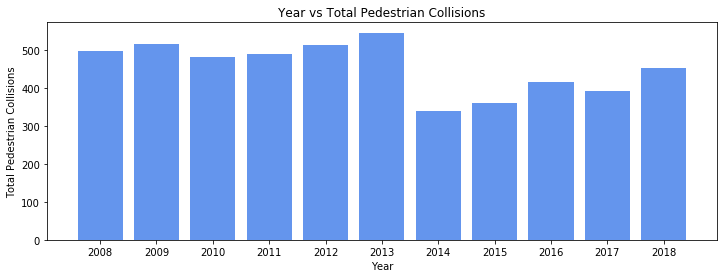

In [135]:
by_year = df.groupby('YEAR').size().reset_index(name='counts')

plt.figure(figsize=[12,4])
plt.bar(by_year['YEAR'], by_year['counts'], color='cornflowerblue')
plt.title('Year vs Total Pedestrian Collisions')
plt.xlabel('Year')
plt.ylabel('Total Pedestrian Collisions')
plt.xticks(by_year['YEAR'])
plt.show()

Let's look at the trend over months 

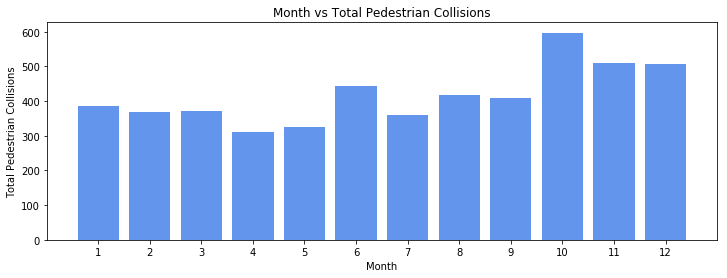

In [136]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['MONTH'] = df['DATE'].dt.month

by_month = df.groupby('MONTH').size().reset_index(name='counts')

plt.figure(figsize=[12,4])
plt.bar(by_month['MONTH'], by_month['counts'], color='cornflowerblue')
plt.title('Month vs Total Pedestrian Collisions')
plt.xlabel('Month')
plt.ylabel('Total Pedestrian Collisions')
plt.xticks(by_month['MONTH'])
plt.show()

Let's look at the trend over age groups

C:\Users\builder\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


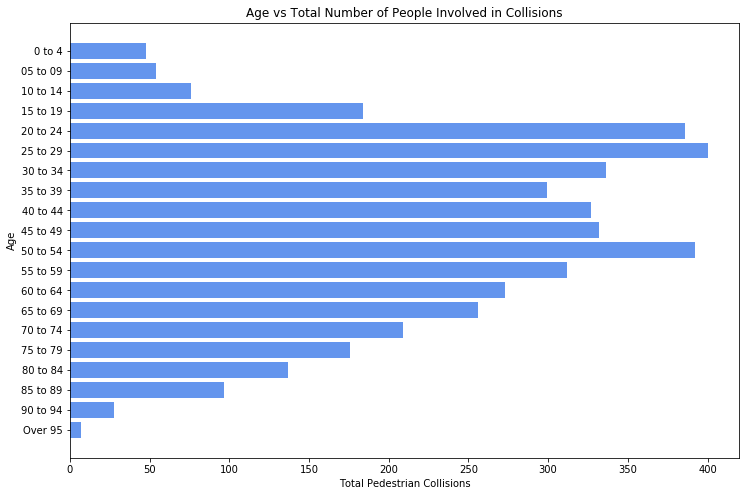

In [167]:
by_age = df.groupby('INVAGE').size().reset_index(name='counts').drop(20)
by_age['INVAGE'][9] = '05 to 09'
by_age = by_age.sort_values(by='INVAGE', ascending=False)

plt.figure(figsize=[12,8])
plt.barh(by_age['INVAGE'], by_age['counts'], color='cornflowerblue')
plt.title('Age vs Total Number of People Involved in Collisions')
plt.xlabel('Total Pedestrian Collisions')
plt.ylabel('Age')
plt.show()

When you observe the above bar graph, age groups in working age have high total pedestrian collisions. There are two peaks at 25-29 and 50-54. This was difficult to interpret so I plotted separte bar graphs for pedestrians and drivers. Might as well do it now.  

C:\Users\builder\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


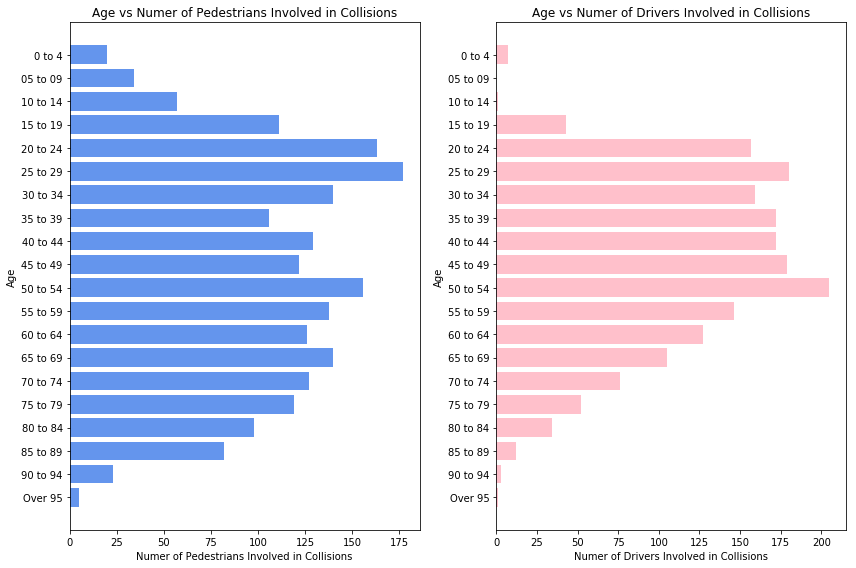

In [179]:
# pedestrians
only_ped = df[df['INVTYPE'] == 'Pedestrian']
only_ped = only_ped.groupby('INVAGE').size().reset_index(name='counts').drop(20)
only_ped['INVAGE'][9] = '05 to 09'
only_ped = only_ped.sort_values(by='INVAGE', ascending=False)

# drivers
only_driv = df[df['INVTYPE'] == 'Driver']
only_driv = only_driv.groupby('INVAGE').size().reset_index(name='counts').drop(19)
only_driv = only_driv.append({'INVAGE':'05 to 09', 'counts':0}, ignore_index=True)
only_driv = only_driv.sort_values(by='INVAGE', ascending=False)

plt.subplots(1,2, figsize=[12,8])

# pedestrians
plt.subplot(1,2,1)
plt.barh(only_ped['INVAGE'], only_ped['counts'], color='cornflowerblue')
plt.title('Age vs Numer of Pedestrians Involved in Collisions')
plt.xlabel('Numer of Pedestrians Involved in Collisions')
plt.ylabel('Age')

# drivers
plt.subplot(1,2,2)
plt.barh(only_driv['INVAGE'], only_driv['counts'], color='pink')
plt.title('Age vs Numer of Drivers Involved in Collisions')
plt.xlabel('Numer of Drivers Involved in Collisions')
plt.ylabel('Age')

plt.tight_layout()

plt.show()

First of all, looking at the observations, there are drivers in age group 0-4?? Okay, I definitely need to look at the rows for drivers between age 0 to 4. But before doing that, we can observe that the significant difference from the bar graph of the total number of people to the separated bar graphs is that: 
1. When just looking at pedestrians, largest number of people in their 20s and this intuitively makes sense as there are a lot of students in their 20s commuting downtown. 
2. When just looking at drivers, largest number of people between 55-59 and they happened to be at the higher end of working age. 

Okay, I know I get side-tracked often but I need to see where these drivers between 0-4 come from. Let's explore that. 

In [184]:
df[(df['INVAGE'] == '0 to 4') & (df['INVTYPE'] == 'Driver')]

,X,Y,Index_,ACCNUM,YEAR,DATE,TIME,Hour,STREET1,STREET2,OFFSET,ROAD_CLASS,District,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Division,Ward_Name,Ward_ID,Hood_ID,Hood_Name,ObjectId
1275,-79.403927,43.673202,80946952,8001252382,2018,2018-07-09T04:00:00.000Z,2148,21,PRIVATE LANEWAY,620 HURON STREET,10 m West of,Local,Toronto and East York,43.673202,-79.403927,,At/Near Private Drive,No Control,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,0 to 4,None,0,South,"Automobile, Station Wagon",Going Ahead,Lost control,Unknown,,,,,,,Yes,,Yes,,,NaN,,Yes,Yes,Yes,,,,53,NaN,NaN,95,NaN,4276
1664,-79.401439,43.781711,80974089,8001972538,2018,2018-10-25T04:00:00.000Z,2020,20,WILFRED AV,WILFRED AV,20 m North of,Collector,North York,43.781711,-79.401439,Intersection,Intersection Related,No Control,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,0 to 4,None,0,Unknown,,Unknown,Other,Unknown,,,,,,,Yes,,,,,NaN,,,,,,,,32,NaN,NaN,51,NaN,4665
2160,-79.476414,43.665538,81074570,8001717185,2018,2018-09-16T04:00:00.000Z,1329,13,DUNDAS ST W,ST JOHN'S PL,52 m West of,Major Arterial,Toronto and East York,43.665538,-79.476414,Mid-Block,Non Intersection,No Control,Clear,Daylight,Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,0 to 4,None,0,East,,Going Ahead,Other,Unknown,,,,,,,Yes,,,,,NaN,,,,,,,,11,NaN,NaN,90,NaN,2163
3200,-79.494472,43.781570,80949321,8001542376,2018,2018-08-21T04:00:00.000Z,630,6,KEELE STREET,STEELES AVENUE WEST,,Major Arterial,North York,43.781570,-79.494472,Intersection,At Intersection,Traffic Signal,Clear,"Dawn, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,0 to 4,None,0,North,"Automobile, Station Wagon",Turning Left,Failed to Yield Right of Way,Unknown,,,,,,,Yes,,Yes,,,NaN,,,,Yes,,,,31,NaN,NaN,27,NaN,203
3531,-79.507900,43.759284,80945641,8001140010,2018,2018-06-23T04:00:00.000Z,205,2,FINCH AVE W,TOBERMORY DR,,Major Arterial,Etobicoke York,43.759284,-79.507900,Intersection,At Intersection,Traffic Signal,Rain,"Dark, artificial",Wet,Non-Fatal Injury,Pedestrian Collisions,Driver,0 to 4,None,0,West,"Automobile, Station Wagon",Going Ahead,Speed too Fast For Condition,Unknown,,,,,,,Yes,,Yes,,,NaN,,,Yes,Yes,,,,31,NaN,NaN,25,NaN,534
3700,-79.244685,43.744784,80769556,6001406724,2016,2016-08-10T04:00:00.000Z,329,3,DANFORTH RD,THICKETWOOD DR (431),,Major Arterial,Scarborough,43.744784,-79.244685,Intersection,Intersection Related,Stop Sign,Clear,"Daylight, artificial",Wet,Non-Fatal Injury,Pedestrian Collisions,Driver,0 to 4,None,0,Unknown,,Going Ahead,Driving Properly,Unknown,,,,,,,Yes,,,,,NaN,,,,,,,,43,NaN,NaN,138,NaN,703
4557,-79.444820,43.691237,80784554,6001603750,2016,2016-09-09T04:00:00.000Z,1733,17,LAUDER AVE,AMHERST AVE,100 m North of,Local,Scarborough,43.691237,-79.444820,Mid-Block,Laneway,No Control,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,0 to 4,None,0,Unknown,,Unknown,Other,Unknown,,,,,,,Yes,,,,,NaN,,,,,,,,13,NaN,NaN,107,NaN,3560


Looking at the at the filtered data, I still don't understand fully how 0 to 4 years old became a driver and was involved in collisions but it is very unfortunate. 

Now, let's group the dataset over Toronto neighbourhoods. 

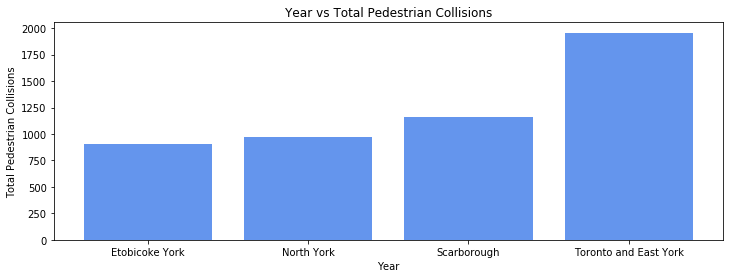

In [192]:
by_districts = df.groupby('District').size().reset_index(name='counts').drop([0, 4]).sort_values(by='counts')

plt.figure(figsize=[12,4])
plt.bar(by_districts['District'], by_districts['counts'], color='cornflowerblue')
plt.title('Year vs Total Pedestrian Collisions')
plt.xlabel('Year')
plt.ylabel('Total Pedestrian Collisions')
plt.xticks(by_districts['District'])
plt.show()

Highest number of collisions in Toronto and East York. I believe Toronto and East York includes Downtown Toronto and that is why the number is high. 

### Future areas of interest 

1. The dataset has a lot of features and it would be interesting to look into other features like type of injuries, weather and vehicle types
2. For the neighbourhood, instead of grouping by districts, group them into neighbourhoods based on the latitude and longitude of the collision incidents. It will give more accurate results. 


### Resources

1. https://data.torontopolice.on.ca/datasets/pedestrians